### dSL, dSr 2그룹 환경변수 통합

In [1]:
import pandas as pd

origin_data1 = pd.read_csv('data2/CGM1_dS&dSr.csv', encoding='cp949')
origin_data2 = pd.read_csv('data2/CGM2_dS&dSr.csv', encoding='cp949')
origin_data3 = pd.read_csv('data2/CGM3_dS&dSr.csv', encoding='cp949')
origin_data4 = pd.read_csv('data2/CGM4_dS&dSr.csv', encoding='cp949')

In [2]:
def filter_data(origin_data, columns):
    data = origin_data[columns]
    data = data[data["Glu2(mg/dl)"] > 0]
    return data

common_var = ["Glu2(mg/dl)", "LD1 Temp", "LD2 Temp", "LD3 Temp", "Rx1 Temp", "Rx2 Temp", "S1 T(C)", "S2 T(C)", "S3 T(C)", "FR Mon", "LD_Bias_Av",
             "mPD1_dS", "mPD2_dS", "mPD3_dS", "T-rPD_L1dS", "T-rPD_L2dS", "T-rPD_L3dS", "R-rPD_L1dS", "R-rPD_L2dS", "R-rPD_L3dS",
             "mPDdSr31", "mPDdSr32", "mPDdSr21", "T-rPDdSr31", "T-rPDdSr32", "T-rPDdSr21", "R-rPDdSr31", "R-rPDdSr32", "R-rPDdSr21"]

dataR1 = filter_data(origin_data1, common_var)
dataR2 = filter_data(origin_data2, common_var)
dataR3 = filter_data(origin_data3, common_var)
dataR4 = filter_data(origin_data4, common_var)


# cgm3는 제외
dataR = pd.concat([dataR1, dataR2, dataR4])

print(len(dataR1), len(dataR2), len(dataR3), len(dataR4), len(dataR))

295 106 187 342 743


In [3]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def preprocess(data , dt=False) -> tuple:
    if dt:
        data = data.astype({'Glu2(mg/dl)':'int'})
    
    X = data.drop('Glu2(mg/dl)', axis=1).values
    y = data['Glu2(mg/dl)'].values
    y = y.round(0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return torch.tensor(X_train, dtype=torch.float32), \
        torch.tensor(y_train, dtype=torch.float32), \
        torch.tensor(X_test, dtype=torch.float32), \
        torch.tensor(y_test, dtype=torch.float32)

dataR = preprocess(dataR, True)

In [4]:
from torch import onnx

def train_model(model, train_loader, num_epochs, learning_rate, name:str):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    epoch_losses = []
    for epoch in tqdm(range(num_epochs), desc=f'Train {name}'):
        total_loss = 0
        total_batches = 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            with torch.set_grad_enabled(True):
                y_hat = model(X)
                loss = criterion(y_hat.squeeze(), y)
                total_loss += loss.item()
                total_batches += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = total_loss / total_batches
        epoch_losses.append(epoch_loss)
    
    torch.save(model.state_dict(), f'property2/{name}.pt')
    onnx.export(model, X.to(device), f'property2/{name}.onnx')
    return epoch_losses

In [5]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8
num_epochs = 100
learning_rate = 0.001

train_loaderR = DataLoader(TensorDataset(dataR[0].unsqueeze(1), dataR[1]), batch_size=batch_size, shuffle=True)

In [6]:
from model import MLP, Conv1DModel, LinearRegressionModel

model_conv = Conv1DModel(1, 2)
losses_conv1d = train_model(model_conv, train_loaderR, num_epochs, learning_rate, 'conv1d')

model_mlp = MLP(28)
losses_mlp = train_model(model_mlp, train_loaderR, num_epochs, learning_rate, 'mlp')

Train conv1d: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]
C:\Work\CGM\ETRI_CGM_Analysis_ModelDev\JaeseongArea\model\_1d_conv_net.py:28: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  x = functional.avg_pool1d(x, kernel_size=int(x.size(dim=2)))
Train mlp: 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.22it/s]


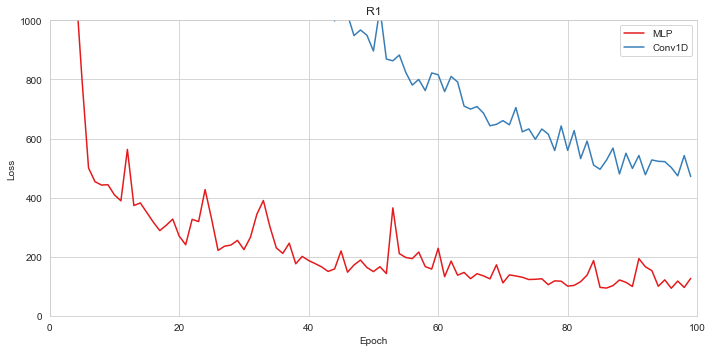

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_graph(ax, loss_mlp, loss_conv1d, title):
    ax.plot(loss_mlp, label='MLP')
    ax.plot(loss_conv1d, label='Conv1D')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.set_ylim(0, 1000)
    ax.set_xlim(0, num_epochs)

    
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
draw_graph(ax1, losses_mlp, losses_conv1d, 'R1')

plt.tight_layout()
plt.show()

In [8]:
import numpy
from sklearn.metrics import mean_squared_error, r2_score

def model_infer(model, loder) -> tuple:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in loder:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            y_pred.append(y_hat.cpu().numpy())
            y_true.append(y.cpu().numpy())
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2  

def append_graph(ax, y, y_pred, title):
    ax.scatter(y, y_pred, s=1, label=title)# 'MLP_L23'
    ax.plot([75, 200], [75, 200], 'k--')
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.set_title(f'{title} (RMS: {rms:.2f}, R2: {r2:.2f})')

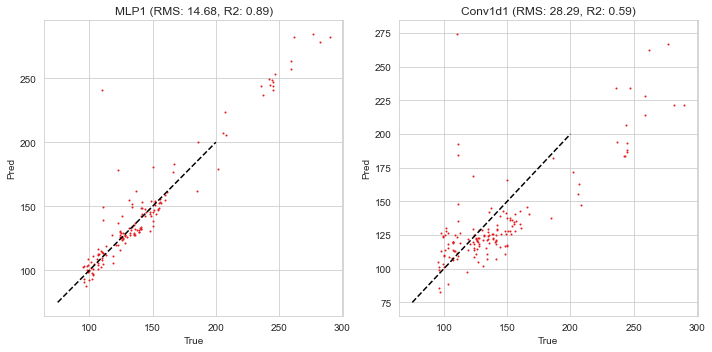

In [9]:
import numpy
import csv

test_loaderR = DataLoader(TensorDataset(dataR[2].unsqueeze(1), dataR[3]), batch_size=1, shuffle=True)

sns.set_style('whitegrid')
sns.set_palette('Set1')

fig, (ax1) = plt.subplots(1, 2, figsize=(10, 5))

y_pred_m, y_true_m, rms, r2 = model_infer(model_mlp, test_loaderR)
append_graph(ax1[0], y_true_m, y_pred_m, 'MLP1')
y_pred_c, y_true_c, rms, r2 = model_infer(model_conv, test_loaderR)
append_graph(ax1[1], y_true_c, y_pred_c, 'Conv1d1')


plt.tight_layout()
plt.show()

min_count = len(y_pred_m)


mlp_data = [['Concat', 'true', 'pred']]
for n in range(0, min_count):
    mlp_data.append(['', y_true_m[n], y_pred_m[n][0][0]])

f_mlp = open('result/mlp_concat_result.csv','w', newline='')
writer = csv.writer(f_mlp)
writer.writerows(mlp_data)
f_mlp.close()


conv_data = [['Concat', 'true', 'pred']]
for n in range(0, min_count):
    conv_data.append(['', y_true_c[n], y_pred_c[n][0]])

f_conv = open('result/conv_concat_result.csv','w', newline='')
writer = csv.writer(f_conv)
writer.writerows(conv_data)
f_conv.close()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

RF = RandomForestClassifier(max_depth=20, n_estimators=100, random_state=0)
GB = GradientBoostingClassifier(max_depth=10, n_estimators=100, random_state=0)

In [11]:
num_epochs = 3

for epoch in tqdm(range(num_epochs), desc=f'Train {str}'):
    RF.fit(dataR[0], dataR[1])
    GB.fit(dataR[0], dataR[1])

Train <class 'str'>: 100%|██████████████████████████████████████████████████████████████| 3/3 [14:32<00:00, 290.96s/it]


In [12]:
import pandas as pd

def make_result_sample(data, model, count):
    y_h = []; pred = []
    for i in range(0, count):
        y_h.append(data[3][i])
        
        result = model.predict([data[2][i].tolist()])
        pred.append(result)
    
    return y_h, pred

statistic_RF = pd.DataFrame(columns=["RF1_y","RF1_pred","RF2_y","RF2_pred","RF3_y","RF3_pred",
                                        "RF21_y","RF21_pred","RF31_y","RF31_pred","RF32_y","RF32_pred"])
statistic_GB = pd.DataFrame(columns=["GB1_y","GB1_pred","GB2_y","GB2_pred","GB3_y","GB3_pred",
                                        "GB21_y","GB21_pred","GB31_y","GB31_pred","GB32_y","GB32_pred"])

In [1]:
def model_infer(model, loder) -> tuple:
    y_pred = []
    y_true = []

    for X, y in loder:
        y_hat = model.predict(X.squeeze(0).tolist()) # model(X)
        y_hat = torch.Tensor(y_hat)
        y_pred.append(y_hat.cpu().numpy())
        y_true.append(y.cpu().numpy())
        
    y_pred = numpy.concatenate(y_pred)
    y_true = numpy.concatenate(y_true)
    rms = numpy.sqrt(mean_squared_error(y_true, y_pred.squeeze()))
    r2 = r2_score(y_true, y_pred.squeeze())
    return y_pred, y_true, rms, r2

def draw_DTgraph(ax, model, loader, title):
    y_pred, y_true, rms, r2 = model_infer(model, loader)
    ax.scatter(y_true, y_pred, s=1, label=title)
    ax.plot([75, 300], [75, 300], 'k--')
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.set_title(f'{title} (RMS: {rms:.2f}, R2: {r2:.2f})') # f'R31 RandomForest (RMS: {rms:.2f}, R2: {r2:.2f})'

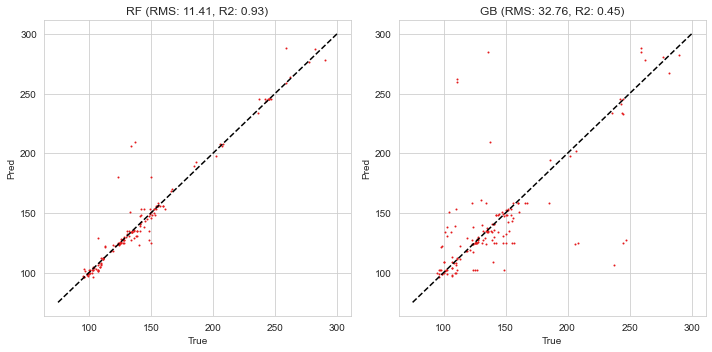

['property2/gb_test.joblib']

In [23]:
fig, (ax1) = plt.subplots(1, 2, figsize=(10, 5))
draw_DTgraph(ax1[0], RF, test_loaderR, 'RF')
draw_DTgraph(ax1[1], GB, test_loaderR, 'GB')

plt.tight_layout()
plt.show()

import joblib

joblib.dump(RF, "property2/rf_test.joblib")
joblib.dump(GB, "property2/gb_test.joblib")